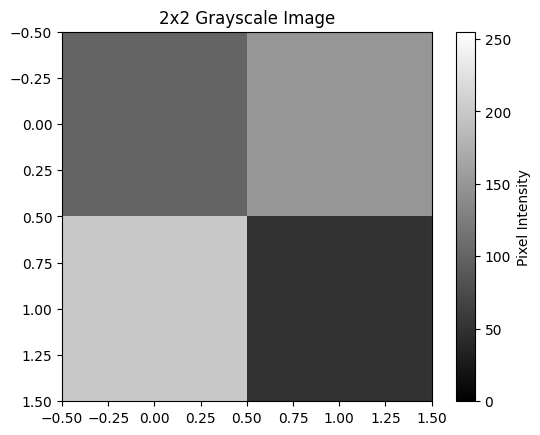

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a 2x2 grayscale image (values range from 0 to 255)
image = np.array([[100, 150], [200, 50]], dtype=np.uint8)

# Display the image
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.colorbar(label='Pixel Intensity')
plt.title("2x2 Grayscale Image")
plt.show()


In [99]:
M = 256
phi = []
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        num = np.pi * image[i, j] - 1
        deno = 2 * 255 
        phi.append(num / deno)
phi = np.array(phi)
phi

array([0.61403778, 0.92203705, 1.23003633, 0.3060385 ])

In [100]:
theta = []
deno = np.sqrt(np.sum(phi ** 2))
for ai in phi:
    theta.append(ai / deno)
theta = np.array(theta)
theta

array([0.36475995, 0.54772231, 0.73068467, 0.18179759])

In [101]:
def calculate_alpha(theta, qubit_levels, current_level=1):

    alpha = []
    step_size = 2**(qubit_levels - current_level)  # Number of states per group
    for i in range(0, len(theta), step_size * 2):
        sum_0 = np.sum(theta[i:i+step_size]**2)
        sum_1 = np.sum(theta[i+step_size:i+2*step_size]**2)
        alpha_angle = np.arctan(np.sqrt(sum_1 / sum_0)) if sum_0 != 0 else np.pi/2
        alpha.append(alpha_angle)
    return alpha

In [102]:
alpha_values_2x2 = {}
for qubit in range(1, 3):
    alpha_values_2x2[f'Level {qubit}'] =  calculate_alpha(theta, 2, qubit)


In [103]:
alpha_values_2x2

{'Level 1': [np.float64(0.8525503105749996)],
 'Level 2': [np.float64(0.9832846327355295), np.float64(0.24385310944496344)]}

In [104]:
import pennylane as qml
from pennylane import numpy as np

# Define the device with 2 qubits (no segmentation)
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits, shots = 100000)

# Given alpha values
alpha_1 = np.float64(0.8525503105749996)  # Level 1
alpha_2 = [np.float64(0.9832846327355295), np.float64(0.24385310944496344)]  # Level 2

@qml.qnode(dev)
def quantum_circuit():
    # Apply the first level of rotation (alpha_1)

    qml.H(wires=[0])
    qml.RX(alpha_1, wires=0)
    
    # Apply the second level of rotations (alpha_2) conditionally
    
    qml.CRX(alpha_2[0], wires=[0, 1])  # Conditional rotation for the first group
    
    
    qml.X(wires = [0])
    qml.CRX(alpha_2[1], wires=[0, 1])  # Conditional rotation for the second group
    
    
    # Return the state
    return qml.probs(range(n_qubits))

drawer = qml.draw(quantum_circuit)
print(drawer())
print('\n')
# Run the circuit
quantum_state = quantum_circuit()
print("Quantum State:", quantum_state)


0: ──H──RX(0.85)─╭●─────────X─╭●────────┤ ╭Probs
1: ──────────────╰RX(0.98)────╰RX(0.24)─┤ ╰Probs


Quantum State: [0.38561 0.10951 0.49722 0.00766]


In [108]:
pixel_intensities = quantum_state * np.sqrt(np.sum(quantum_state))
pixel_intensities = pixel_intensities / np.max(256)
pixel_intensities = pixel_intensities * 100
print("Pixel Intensities (Normalized):", pixel_intensities)

Pixel Intensities (Normalized): [0.15062891 0.04277734 0.19422656 0.00299219]


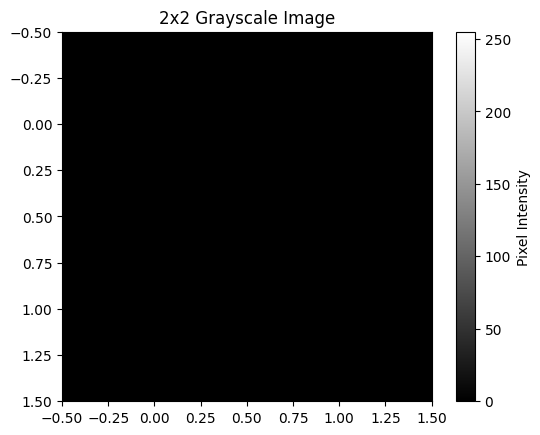

In [109]:
image = pixel_intensities.reshape((2, 2))
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.colorbar(label='Pixel Intensity')
plt.title("2x2 Grayscale Image")
plt.show()


In [110]:
image

array([[0.15062891, 0.04277734],
       [0.19422656, 0.00299219]])